In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pywt
import plotly.express as px
import scipy.signal as scisig
from sklearn.decomposition import FastICA

In [2]:
from data_handling import LaserDataInteractorESRF
from data_processing import ProcessingUtil as processor

## Load + process (lowpass + downsample)

In [3]:
# Known measurmeent variables
fs = 6.25* 10**6 #[Hz]
dt = 1/fs #[s]

# On data
fileNo = 18
chNo = 1

path_rel = '/Volumes/Sandisk_SD/Work/IZFP/Laser/03_ESRF/Code/measurements/ESRF_TU_Ilmenau_IZFP/Messdaten_QASS'

In [4]:
interactor = LaserDataInteractorESRF()
interactor.path_rel = path_rel
# Ch.1
interactor.fname = (1, fileNo) # ChNo, fileNo
sig1, _ = interactor.load_data(ret_dt=True)
sig1 -= sig1.mean()
# Ch.2
interactor.fname = (2, fileNo) # ChNo, fileNo
sig2, _ = interactor.load_data(ret_dt=True)
sig2 -= sig2.mean()


In [5]:
# Downsample, because the signal is way too long...
# Parameters: 
fmax = 400*10**3 # [Hz] -> based on the spectrogram --> then, we can downsample by 3

# (2) Downsample in freq. domain
ds = 4 # downsample factor

In [6]:
#data_proc = processor.apply_bandpass(data, f_range=[fmin, fmax], dt=dt)
data_proc = processor.apply_lowpass(sig1, cutoff=fmax, dt=dt)
freps = np.sqrt(ds)* np.fft.rfft(data_proc)
data_ds, freps_ds = processor.downsample(data_proc, ds, ret_freps=True)
fs_new = fs/ds
dt_new = 1/fs_new
print(f'Bins: was={len(freps)}, is={len(freps_ds)}')
print(f'Time samples: was={len(data_proc)}, is={len(data_ds)}')

Bins: was=2956801, is=739200
Time samples: was=5913600, is=1478398


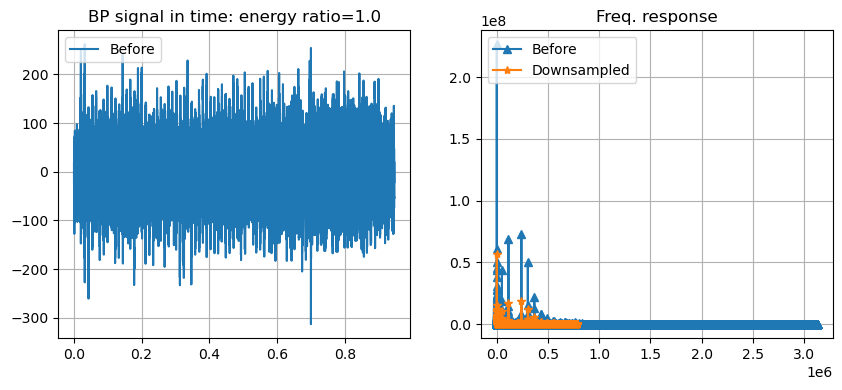

In [7]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

t1 = dt*np.arange(len(data_proc))
axs[0].plot(t1, data_proc, label='Before')
t2 = dt_new*np.arange(len(data_ds))
#axs[0].plot(t2, data_ds, label='Downsampled')

energy1 = np.sum(data_proc**2)
energy2 = np.sum(data_ds**2)
axs[0].set_title(f'BP signal in time: energy ratio={round(energy1/energy2, 2)}')
axs[0].grid(True)
axs[0].legend(loc='upper left')

num_bins = int(len(freps_ds)/2)
f1 = fs* np.fft.fftshift(np.fft.fftfreq(len(freps))[:ds*num_bins])
axs[1].plot(f1, np.fft.fftshift(np.abs(freps)[:ds*num_bins]), marker = '^', label='Before')
f2 = fs_new*np.fft.fftshift(np.fft.fftfreq(len(freps_ds))[:num_bins])
axs[1].plot(f2, np.fft.fftshift(np.abs(freps_ds)[:num_bins]), marker='*', label='Downsampled')
axs[1].set_title('Freq. response')
axs[1].legend(loc='upper left')

plt.grid(True)
plt.show()

In [8]:
del freps, freps_ds, f1, f2

## Wavelet

In [9]:
# Compute the wavelet packet transform
def comp_wpt(sig, _wavelet, _maxlevel, ret_path=False):
    # (0) Instantiate the WPT class
    wp = pywt.WaveletPacket(sig, _wavelet, maxlevel=_maxlevel, mode='symmetric')
    # (1) WPT
    nodes = wp.get_level(level=_maxlevel, order='freq')
    # (2) Unpack all nodes
    # Determine the maximum size among all node data arrays
    col_size = max(len(node.data) for node in nodes)
    arr = np.zeros((col_size, len(nodes)))
    path = []
    for col, node in enumerate(nodes):
        curr_data = node.data
        arr[:len(curr_data), col] = curr_data
        path.append(node.path)
    if ret_path == True:
        return arr, path
    else:
        return arr
        

In [10]:
# List of wavelet families to test
wavelets = ['db2', 'db3', 'db10']
wt1, path1 = comp_wpt(data_ds, _wavelet=wavelets[-1], _maxlevel=3, ret_path=True)


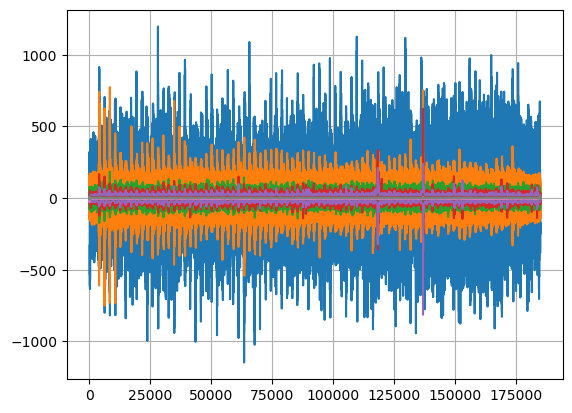

In [30]:
# right now, 
# good nodes = [1, 2, 5, 6, 13, 14]
# noise = [0, 3, 4, 5, 7...12, 15]
plt.plot(wt1)
plt.grid(True)
plt.show()

## ICA to remove the Gaussian noise (i.e. noise of the AE)

In [13]:
# Fast ICA -> into 3 components
transformer = FastICA(n_components=2, random_state=0, whiten='unit-variance')
mix = wt1#np.array((wt1[:, 1], wt1[:, -1])).T
print(mix.shape)
sources1 = transformer.fit_transform(mix)

(184816, 8)


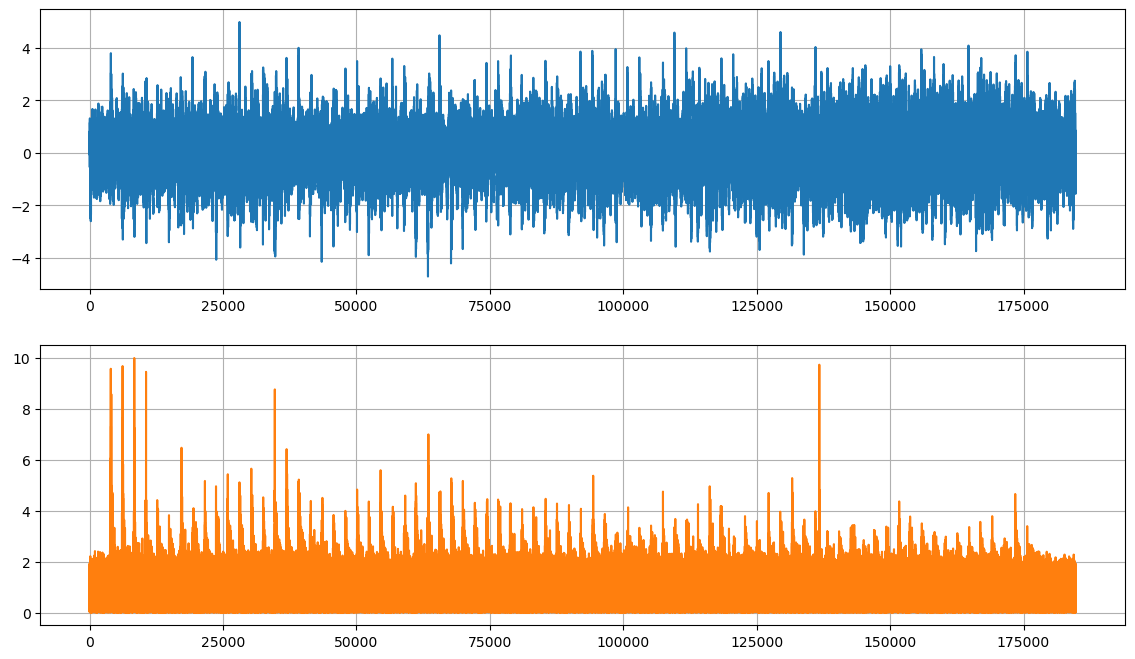

In [21]:
%matplotlib inline
fig, axs = plt.subplots(2, 1, figsize=(14, 8))
t = dt_new* np.arange(sources1.shape[0])

axs[0].plot(sources1[:, 0])
axs[0].grid(True)
axs[1].plot(np.abs(sources1[:, 1]),color='C1')
#axs[1].plot(sources1[:, 0], color='C0')
axs[1].grid(True)

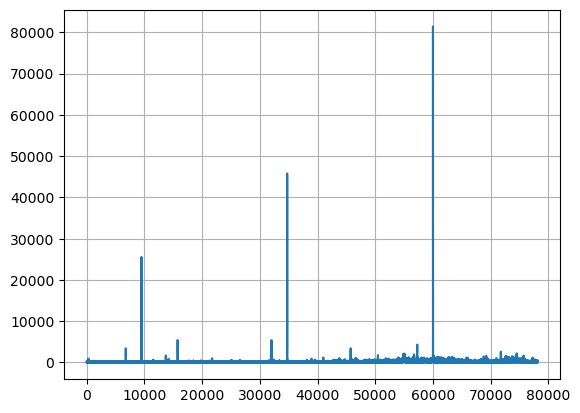

In [15]:
f = 0.1*fs_new* np.fft.rfftfreq(sources1.shape[0])

num_fbins = len(f)
plt.plot(f[:num_fbins], np.abs(np.fft.rfft(sources1[:, 1])[:num_fbins]))
plt.grid(True)

# SVD with two channels

In [ ]:
def process(sig, _fmax, _dt, _ds, _wavelet, _wtlevel):
    # (1) Low-pass
    sig_lp = processor.apply_lowpass(sig, cutoff=_fmax, dt=_dt)
    # (2) Downsample
    sig_new = processor.downsample(sig_lp, _ds)
    # (3) Wavelet 
    wt = comp_wpt(sig_new, _wavelet=_wavelet, _maxlevel=_wtlevel)
    # (4) ICA
    transformer = FastICA(n_components=2, random_state=0, whiten='unit-variance')
    sources = transformer.fit_transform(wt)
    return sources

In [ ]:
# Process the data: downsample + denoise Gaussian component via wavelet and ICA
sources1 = process(sig1, _fmax=fmax, _dt=dt, _ds=ds, _wavelet='db3', _wtlevel=3)
sources2 = process(sig2, _fmax=fmax, _dt=dt, _ds=ds, _wavelet='db3', _wtlevel=3)

In [ ]:
#U, S, _ = np.linalg.svd(np.stack((sources1[:40000, 1], sources2[:40000, 1])).T)

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(2, 1, figsize=(6, 8))
plt.suptitle('901: LP+downsample -> WPT -> ICA -> SVD, first 40k samples')

t = ds* dt* np.arange(sources1.shape[0])
# Sources
axs[0].plot(t, np.abs(sources1[:, 1]), label='Ch1')
axs[0].plot(t, np.abs(sources2[:, 1]), label='Ch2')
axs[0].legend(loc='upper right')
axs[0].grid(True)
axs[0].set_xlabel('t [s]')
axs[0].set_title('Non-Gaussian component')

# Histogram
hist1, bin_edges1 = np.histogram(np.abs(sources1[:, 1]), bins=10, density=True)
hist2, _ = np.histogram(np.abs(sources2[:, 1]), bins=bin_edges1, density=True)
axs[1].plot(bin_edges1[:-1], hist1, label='Ch1')
axs[1].plot(bin_edges1[:-1], hist2, label='Ch2')
axs[1].legend(loc='upper right')
axs[1].grid(True)
axs[1].set_title('Histogram')

plt.show()

In [ ]:
# Convert the results as a pandas dataframe
df = pd.DataFrame(
    data=wt1,
    index=np.arange(wt1.shape[0]),
    columns=np.arange(wt1.shape[1])
)

fig = px.line(
    df.T,
    labels={
        'index': 'XXX',
        'columns': path1,
    },
    title=f'wavelet={wavelets[0]}'
)
fig.show()

In [ ]:
pywt.wavelist(kind='continuous')